In [1]:
cd  /Users/driscoll/Documents/GitHub/fnc/matlab
FNC_init

[**Demo %s**](#demo-diffadv-wave)

We start with the discretization and initial condition.

In [2]:
m = 40; n = 42;
[x, Dx, Dxx] = diffcheb(m, [-2, 2]);
[y, Dy, Dyy] = diffcheb(n, [-2, 2]);
[mtx, X, Y] = tensorgrid(x, y);

u_init = @(x, y) (x+0.2) .* exp(-12*(x.^2 + y.^2));
U0 = mtx(u_init);
V0 = zeros(size(U0));

Note that because $u$ is known on the boundary, while $v$ is unknown over the full grid, there are two different sizes of vec/unvec operations. We also need to define functions to pack grid unknowns into a vector and to unpack them. When the unknowns for $u$ are packed, the boundary values are chopped off, and these are restored when unpacking.

In [3]:
[~, ~, ~, vec_v, unvec_v] = tensorgrid(x, y);
[~, ~, ~, vec_u, unvec_u] = tensorgrid(x(2:m), y(2:n));

chop = @(U) U(2:m, 2:n);
z = zeros(1, n-1);
extend = @(U) [ zeros(m+1, 1) [z; U; z] zeros(m+1, 1)];
pack = @(U, V) [vec_u(chop(U)); vec_v(V)];
N = (m-1) * (n-1);
unpack = @(u) f13_2_wave_unpack(u, N, unvec_u, unvec_v, extend);

```{literalinclude} f13_2_wave_unpack.m
:language: matlab
```


We can now define and solve the IVP. Since this problem is hyperbolic, not parabolic, a nonstiff integrator is faster than a stiff one.

```{literalinclude} f13_2_wave.m
:language: matlab
```

In [4]:
ivp = ode(ODEFcn=@f13_2_wave);
ivp.InitialTime = 0;
ivp.InitialValue = pack(U0, V0);
ivp.Parameters = {Dxx, Dyy, pack, unpack};
ivp.Solver = "nonstiff";
sol = solutionFcn(ivp, 0, 4);

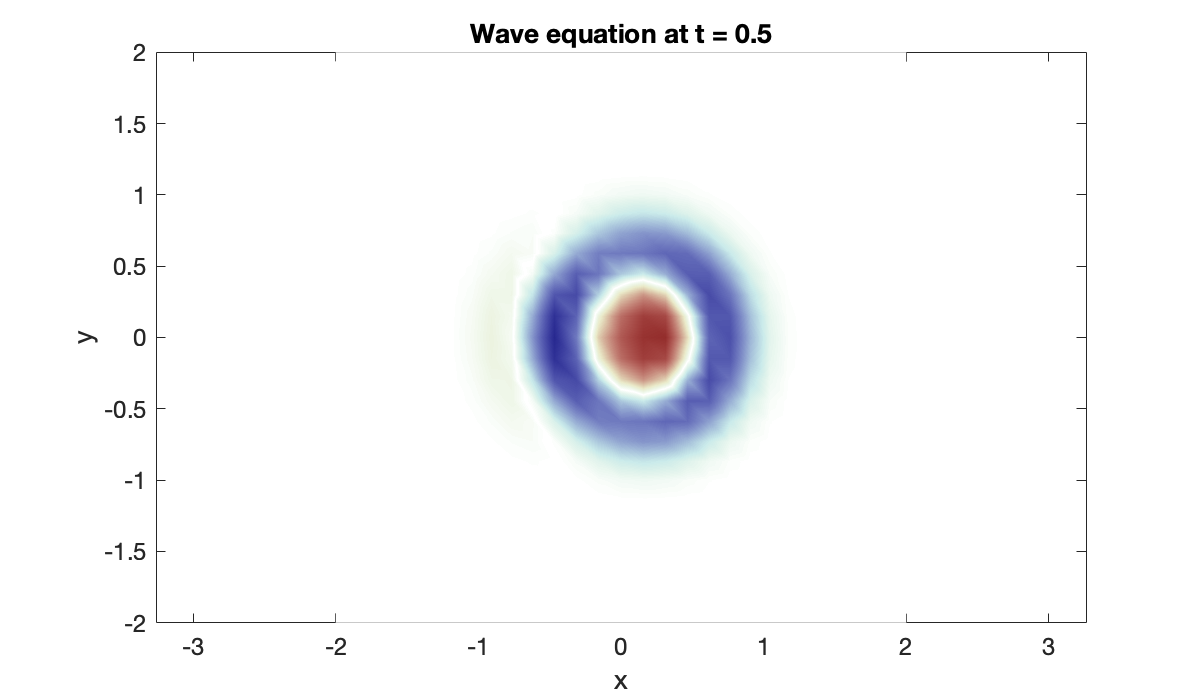

In [5]:
clf
[U, V] = unpack(sol(0.5));
pcolor(X', Y', U')
axis equal,  clim([-0.1, 0.1])
colormap(redsblues),  shading interp
xlabel("x"),  ylabel("y")
title("Wave equation at t = 0.5")

In [ ]:
hold on
vid = VideoWriter("figures/2d-wave.mp4","MPEG-4");
vid.Quality = 85;
open(vid);
for t = linspace(0, 4, 121)
    [U, V] = unpack(sol(t));
    cla, pcolor(X, Y, U)
    shading interp
    str = sprintf("t = %.2f", t);
    text(-3, 1.75, str, fontsize=14);
    writeVideo(vid, frame2im(getframe(gcf)));
end
close(vid)
  